## Spatial derivatives in ESM2M with 
This is a very rough initial run through calculating spatial derivatives in ESM2M. The primary initial part is the calculation of the distances between points, which I do by defining my own _haversine_ function. There are certainly better and more efficient ways to do this.

This notebook uses the `numba` package for efficient calculations on `numpy` arrays. More details [here](http://numba.pydata.org).  

I have not yet been able to get the "metrics" element of `xgcm` working, which is where some of its real power lies. Instead I have just taken a rather straightforward approach to the final differentiation calculation.

In [153]:
from xgcm import Grid
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from numba import jit

In [186]:
# Load data
rootdir = '/local/ss23/GFDL_LEs/'
griddir = 'AREA_FILES_ETC/'
gridname = 'areacella.nc'
datadir = 'OCN/TEMP/RCP85/'
dataname = 'temp_k01_ens101_1x1_1950_2100.nc'
area = xr.open_dataset(rootdir+griddir+gridname)
ds = xr.open_dataset(rootdir+datadir+dataname)

#### Define some functions for calculating and organizing spatial distances between points in the model

In [188]:
@jit(nopython=True)
def haversine_distance(lat1,lat2,lon1,lon2,degrees=True):
    if degrees:
        fac = np.pi/180
        lat1 = lat1*fac
        lat2 = lat2*fac
        lon1 = lon1*fac
        lon2 = lon2*fac
    R = 6371E3
    return 2*R*np.arcsin(np.sqrt(np.sin((lat2-lat1)/2)**2+np.cos(lat1)*np.cos(lat2)*np.sin((lon2-lon1)/2)**2))

@jit(nopython=True)
def calc_spacing_from_latlon(lon_c,lon_g,lon_c_bnds,lon_g_bnds,lat_c,lat_g,lat_c_bnds,lat_g_bnds):
    ni = len(lon_c)
    nj = len(lat_c)
    dxC = np.zeros(shape=(ni,nj))
    dxG = np.zeros(shape=(ni,nj))
    dyC = np.zeros(shape=(ni,nj))
    dyG = np.zeros(shape=(ni,nj))
    for i in range(ni):
        for j in range(nj):
            dxC[i,j] = haversine_distance(lat_c[j],lat_c[j],lon_c_bnds[i,0],lon_c_bnds[i,1],degrees=True)
            dxG[i,j] = haversine_distance(lat_c[j],lat_c[j],lon_g_bnds[i,0],lon_g_bnds[i,1],degrees=True)
            
            dyC[i,j] = haversine_distance(lat_c_bnds[j,0],lat_c_bnds[j,1],lon_c[i],lon_c[i],degrees=True)
            dyG[i,j] = haversine_distance(lat_g_bnds[j,0],lat_g_bnds[j,1],lon_c[i],lon_c[i],degrees=True)
            
    return dxC,dxG,dyC,dyG

def into_arrays(dxC,dxG,dyC,dyG,lon_c,lon_g,lat_c,lat_g):
    dxC = xr.DataArray(dxC,dims=['XG','YC'],coords={'XG':lon_g,'YC':lat_c})
    dxC.name = 'dxC'
    dxG = xr.DataArray(dxG,dims=['XC','YG'],coords={'XC':lon_c,'YG':lat_g})
    dxG.name = 'dxG'
    dyC = xr.DataArray(dyC,dims=['XC','YG'],coords={'XC':lon_c,'YG':lat_g})
    dyC.name = 'dyC'
    dyG = xr.DataArray(dyG,dims=['XG','YC'],coords={'XG':lon_g,'YC':lat_c})
    dyG.name = 'dyG'
    return dxC,dxG,dyC,dyG

#### Calculate distances between data points

In [189]:
# Calculate distances between datapoints
lon_c = ds['xt_ocean'].data
lon_c_bnds = ds['xt_ocean_bnds'].data
lon_g = lon_c-1.25
lon_g_bnds = lon_c_bnds-1.25
lat_c = ds['yt_ocean'].data
lat_c_bnds = ds['yt_ocean_bnds'].data
lat_g = lat_c-1.25
lat_g_bnds = lat_c_bnds-1.25

dxC_vals,dxG_vals,dyC_vals,dyG_vals = calc_spacing_from_latlon(lon_c,lon_g,lon_c_bnds,lon_g_bnds,lat_c,lat_g,lat_c_bnds,lat_g_bnds)
dxC,dxG,dyC,dyG = into_arrays(dxC_vals,dxG_vals,dyC_vals,dyG_vals,lon_c,lon_g,lat_c,lat_g)

rA = xr.DataArray(dxC_vals*dyC_vals,dims=['XC','YC'],coords={'XC':lon_c,'YC':lat_c})
rA.name = 'rA'

#### Build the xgcm grid

In [197]:
# Build a new dataset with all of the grid information
ds_new = ds.copy()
ds_new = ds.rename({'xt_ocean':'XC','yt_ocean':'YC'}).assign_coords({'XG':lon_g,'YG':lat_g}).squeeze()
ds_new = xr.merge([ds_new,dxC,dxG,dyC,dyG,rA])

In [228]:
# Build the grid object
coords = {'X': {'center': 'XC', 'left': 'XG'}, 'Y': {'center': 'YC', 'left': 'YG'}}
grid = Grid(ds_new, periodic=['X'], coords=coords)
grid

<xgcm.Grid>
X Axis (periodic):
  * center   XC --> left
  * left     XG --> center
Y Axis (not periodic):
  * center   YC --> left
  * left     YG --> center

#### Calculate 2D spatial derivatives

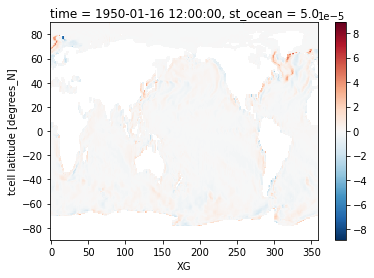

In [238]:
# Take the derivative with a simple difference calculation
# Derivative in the x-direction
dTdx = grid.diff(ds_new['temp'], 'X')/ds_new['dxC']
dTdx.isel(time=0).plot()

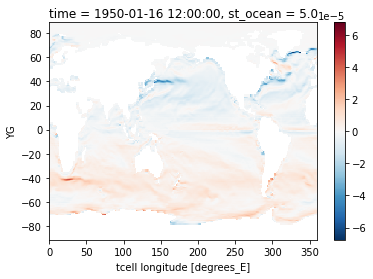

In [240]:
# Derivative in the y-direction
dTdy = grid.diff(ds_new['temp'],'Y',boundary='fill')/ds_new['dyC']
dTdy.isel(time=0).plot()